In [1]:
from scipy.linalg import solve
# Define the equation parameters
from scipy.special import erfc
import pandas as pd
import numpy as np
import scipy.integrate
from numpy import exp
import matplotlib.pyplot as plt


In [2]:
def mmstests(nx, nt):
    a=0.01
    b=1.0;
    c=0.1;

    L = 1.0
    T = 1.0

    do=0;
    Co=1;
    x = np.linspace(0, L, nx+1)
    t = np.linspace(0, T, nt+1)
    xin = np.linspace(0, L, nx+1);
    d = np.zeros((nx+1, nt+1));
    U_exact= np.zeros((nx+1, nt+1))
    for i in range(nt+1):
        for j in range(nx+1):
            U_exact[j, i] = Co*np.cos(np.pi*(2*x[j]-1))*np.exp(-t[i]) 
    
    fig = plt.figure()  
    plt.imshow((U_exact), cmap='viridis',  extent=[0, L, 0, T], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "Exact - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()
    
    for i in range(nt+1):
        for j in range (nx+1):
            d[j, i] = -(Co*np.exp(-t[i]))*(np.cos(np.pi*(2*x[j]-1)) - 2*b*np.pi*np.sin(np.pi*(2*x[j]-1)) - a*4*(np.pi**2)*np.cos(np.pi*(2*x[j]-1)))-do

    # dt = 0.1*dx**2/D#T/(nt-1)
    # dx = L/(nx+1)
    # Discretization of space and time
    dx = L/(nx)
    dt = T/(nt)
    u = Co*np.cos(np.pi*(2*x-1)) # np.exp(-x**2)#np.sin(np.pi*xin)
    ui = u;
    u_CDI  = u;

    #plt.figure()
    #plt.plot(u, label='Initial')
    def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
        alpha = b*dt/dx
        beta = a*dt/dx**2
        nx = len(u_CDI)-1;
        A = np.zeros((nx+1, nx+1))
        bi = d*dt+u_CDI;
        for j in range(1, len(u_CDI)-1):

            A[j, j-1] = -(beta-alpha/2)
            A[j, j] = 1+2*beta-c*dt
            A[j, j+1] = -(beta+alpha/2)

        # Applying first order Periodic Boundary Condition
        A[0, 0]=(1+2*beta)-c*dt;
        A[0, 1]= (-alpha/2-beta)
        A[0, nx]= (alpha/2-beta)    


        A[nx, 0]= (-alpha/2-beta) ;
        A[nx, nx-1]= (alpha/2 - beta)
        A[nx, nx]= 1+2*beta-c*dt   


        # Applying second order periodic boundary conditions
        # bt = d*dt+u_CDI;
        # kk = np.zeros(2)
        # bi = [*kk, *bt]

        # A[0, 0]=0;
        # A[0, 1]= 1
        # A[0, N]= -1
        # A[0, N+1]=0

        # A[1, 0] = -1
        # A[1,1] = 0
        # A[1, 2] = 1
        # A[1, N-1] = 1
        # A[1, N] = 0 
        # A[1, N+1] = -1


        # Boundary condition
        # A[0, 0] = -3
        # A[0, 1] = 4
        # A[0, 2] = -1
        # bi[0] = 0

        # A[N, N] = 3
        # A[N, N-1] = -4
        # A[N, N-2] = 1
        # bi[N] = 0


        # A[0,0] = 1.0
        # # A[N,N] = 1.0

        # bi[0] = l
        # bi[N] = r


        u_CDI = solve(A, bi)

        return u_CDI



    # Apply the numerical scheme
    # u = np.exp(-((x+0.5)**2)/(0.00125))
    U_CDI = np.zeros((nx+1, nt+1))
    error_2norm_CDI_PSTD = np.zeros(nt+1)
    error_2norm_Exact_CDI = np.zeros(nt+1)
    error_2norm_Exact_PSTD = np.zeros(nt+1)
    
    u_CDI=ui;

    for n in range(nt+1):
        u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d[:, n], dx, dt)
        U_CDI[:, n] = u_CDI
        error =  U_CDI[:, n] - U_exact[:, n]
        
        error_2norm_Exact_CDI[n] =np.linalg.norm(error)/np.sqrt(nx)
        errorCDI = error_2norm_Exact_CDI[n]

    #plt.plot(u_CDI, label='Final')
    #plt.show()
    #plt.close()

    plt.rcParams['font.size'] = 18
    fig = plt.figure() 
    plt.imshow(U_CDI, cmap='viridis', extent=[0, L, 0, T], aspect='auto')
    plt.colorbar()
    title = "CDI - nx = "+str(nx+1)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.show()


    k = 2*np.pi*np.fft.rfftfreq(nx+1, L/(nx))
    k2=k**2;
    
    # Defining variables
    U_ps = np.zeros((nx+1, nt+1))
    u = ui;
    # Solving over time
    for i in range(nt+1): # 

        uk = np.fft.rfft(u)

        uk[:] = (uk[:])/(1-(-a*k**2 + b*1j*k+c)*dt) 
        # print(np.shape(uk))    
        u = np.fft.irfft(uk) + d[:, i]*dt
        U_ps[:, i] = u
        error =  U_CDI[:, i] - u
        error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
        error =  U_ps[:, i] - U_exact[:, i]
        error_2norm_Exact_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
        errorPSTD = error_2norm_Exact_PSTD[i]

    fig = plt.figure()  
    plt.imshow((U_ps), cmap='viridis',  extent=[0, L, 0, T], aspect='auto')
    plt.colorbar()
    plt.title("CD Scheme with PSTD")
    plt.xlabel('Time')
    plt.ylabel('Position')
    title = "PSTDI - nx = "+str(nx+1)
    plt.title(title)
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure()
    plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
    plt.plot(error_2norm_Exact_PSTD[0:nt], '.', label = 'Exact_PSTDI')
    plt.plot(error_2norm_Exact_CDI[0:nt], '.', label = 'Exact_CDI')
    
    plt.legend()
    plt.show()
    plt.close()


    plt.figure();
    plt.plot(x, ui, '-', color='g', label = 'Initial'); 
    plt.plot(x, U_exact[:, nt-1], '-*', color='c', label = 'Exact'); 

    plt.plot(x, U_CDI[:, nt-1], '-*', color='b', label = 'CDI Method'); 
    plt.plot(x, U_ps[:, nt-1], '-+', color = 'r', label = 'Spectral Method');
    res =  [U_CDI[:, nt-1], U_ps[:, nt-1]]

    plt.legend(loc="upper right")
    title = "Comparison - nx = "+str(nx+1)
    plt.title(title)
    plt.show()
    plt.close()
    errornorms = np.ones(2)
    errornorms[0] = errorCDI
    errornorms[1] = errorPSTD
    return errornorms





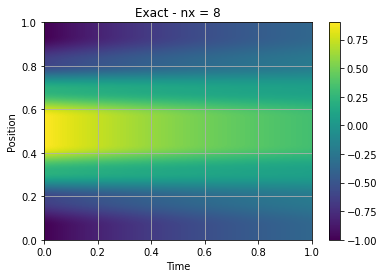

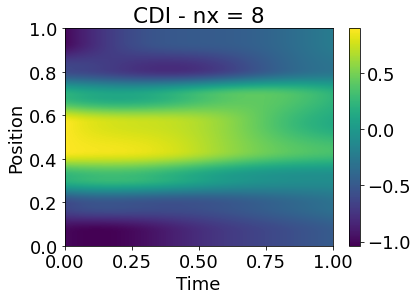

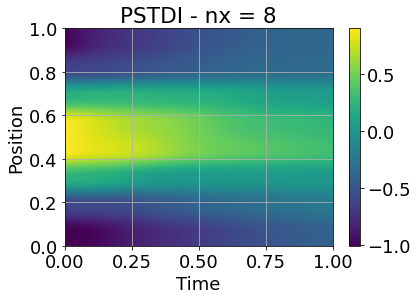

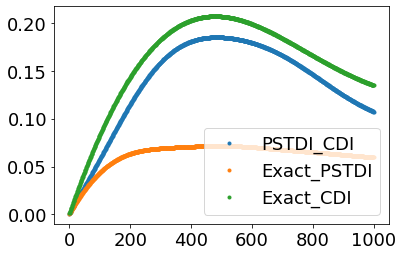

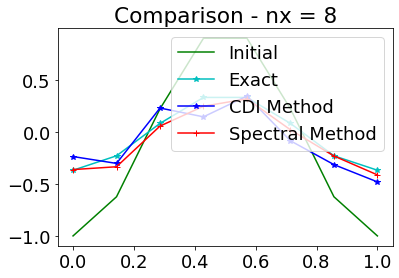

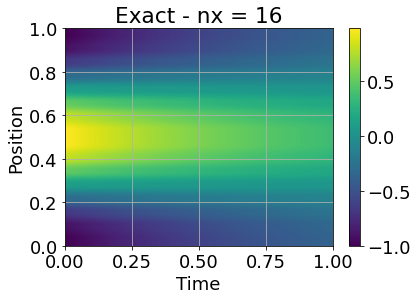

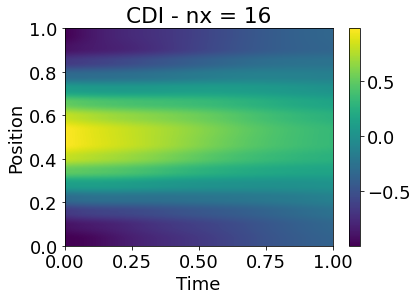

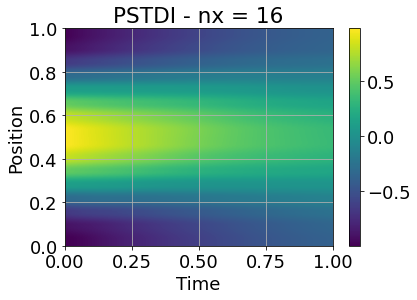

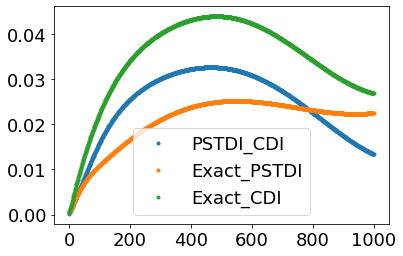

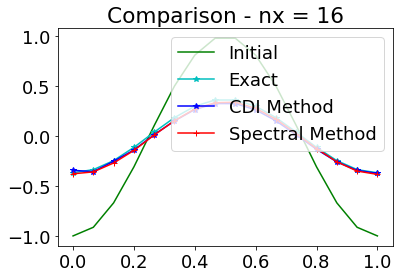

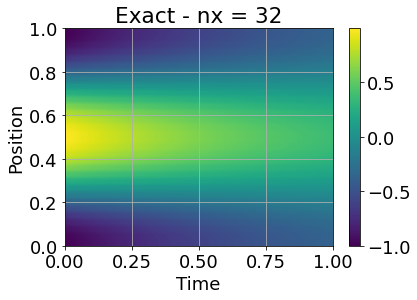

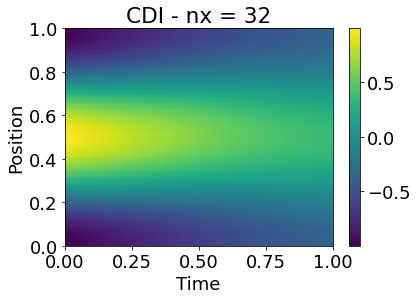

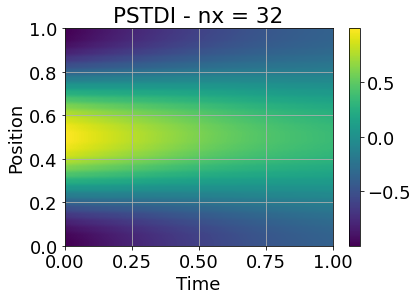

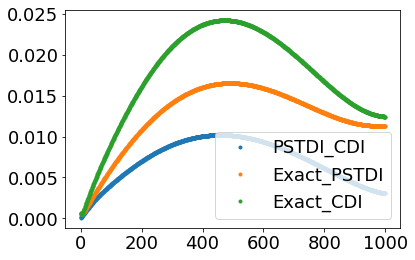

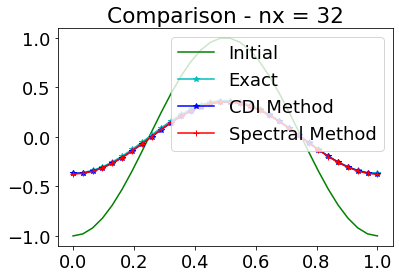

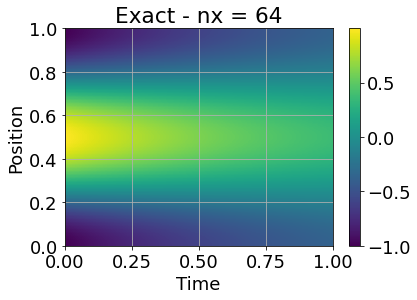

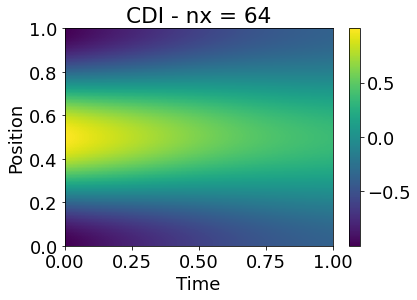

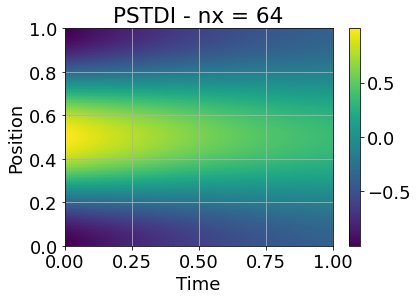

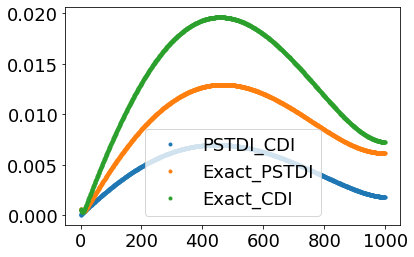

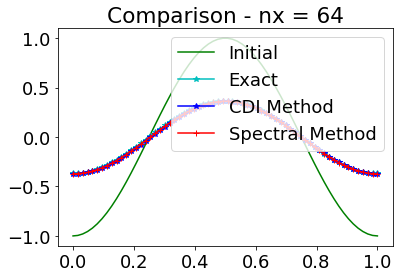

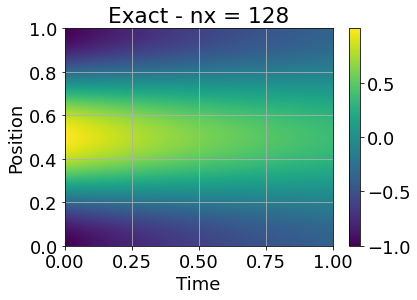

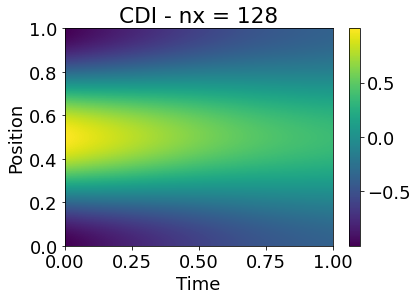

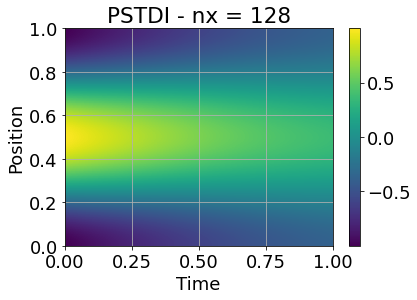

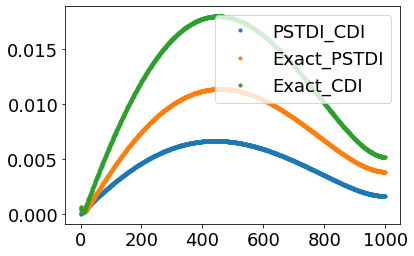

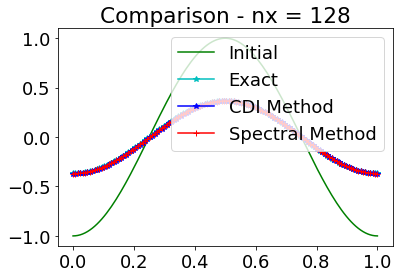

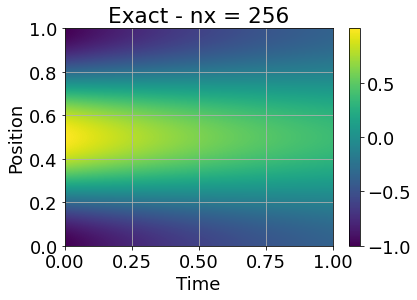

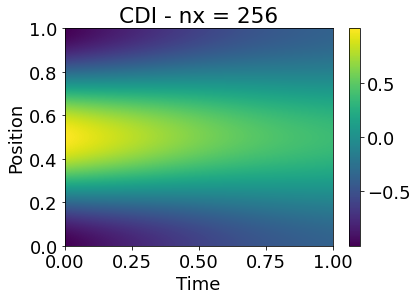

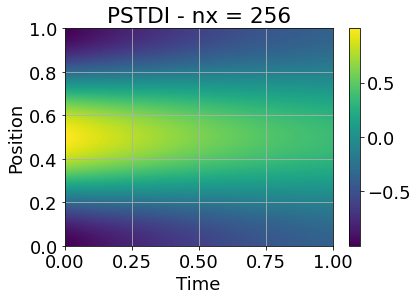

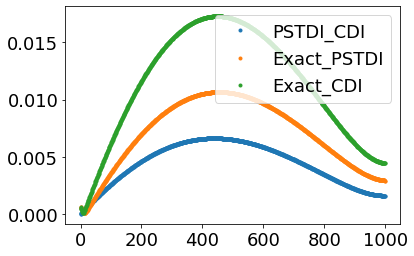

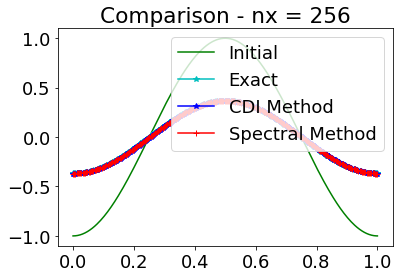

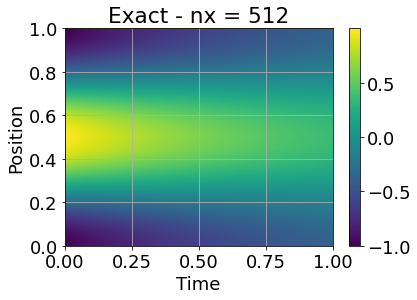

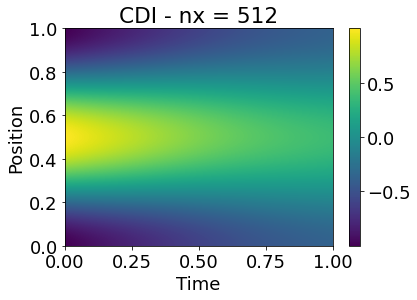

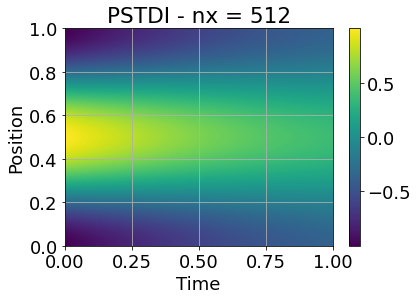

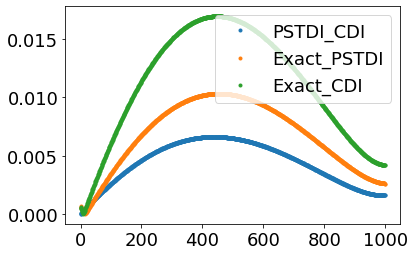

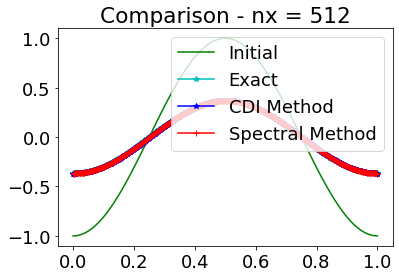

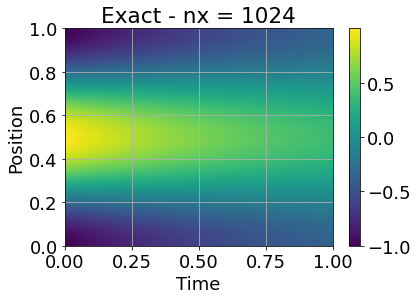

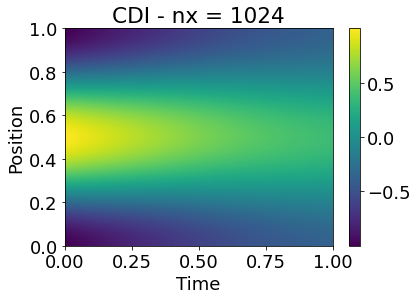

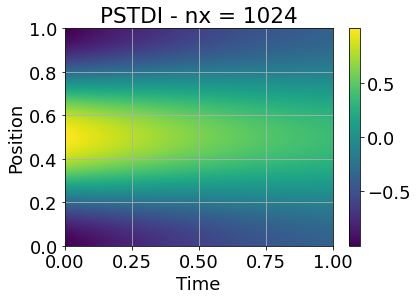

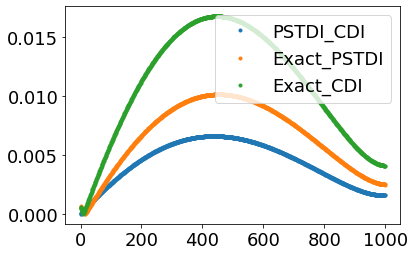

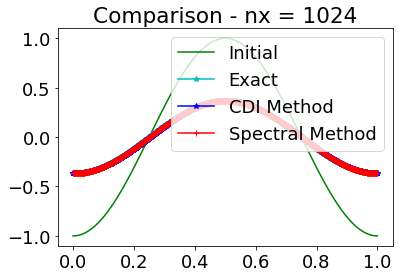

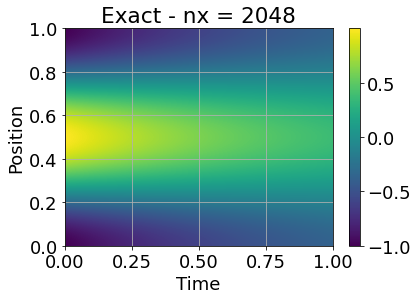

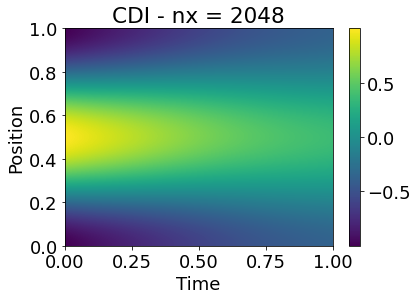

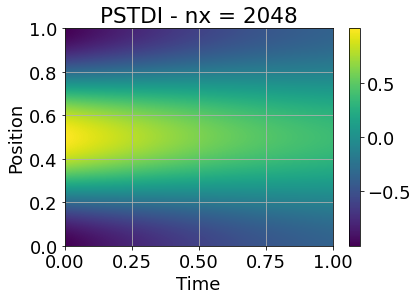

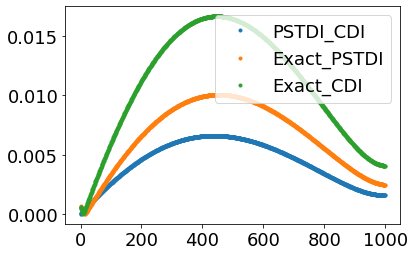

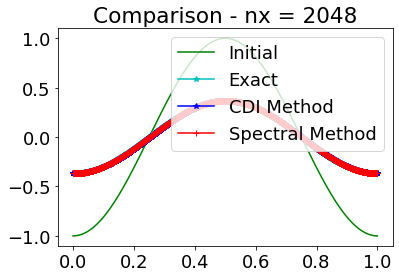

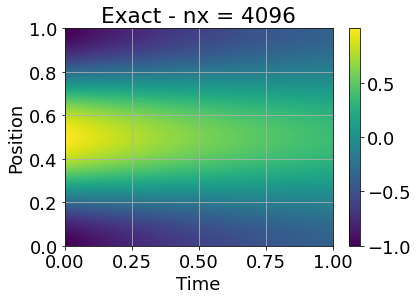

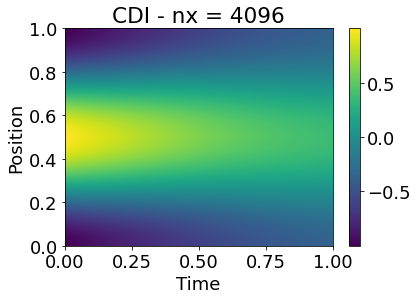

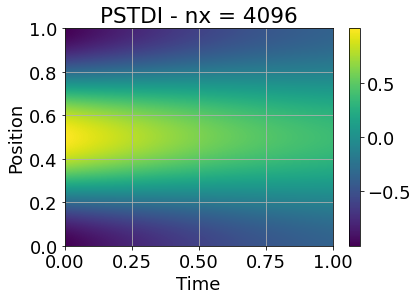

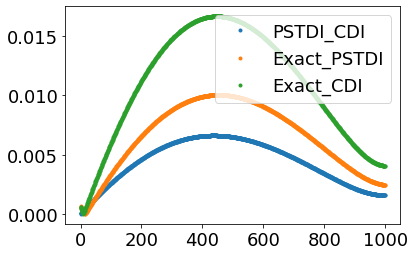

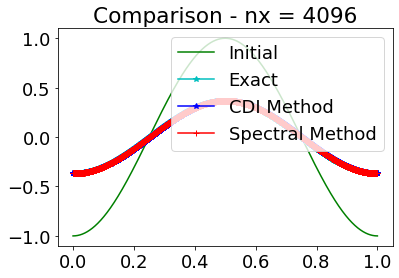

<Figure size 720x144 with 0 Axes>

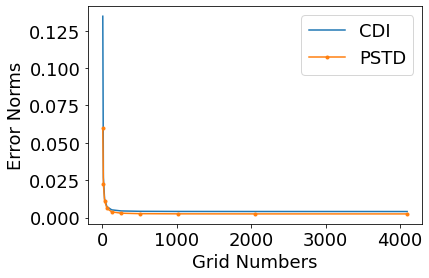

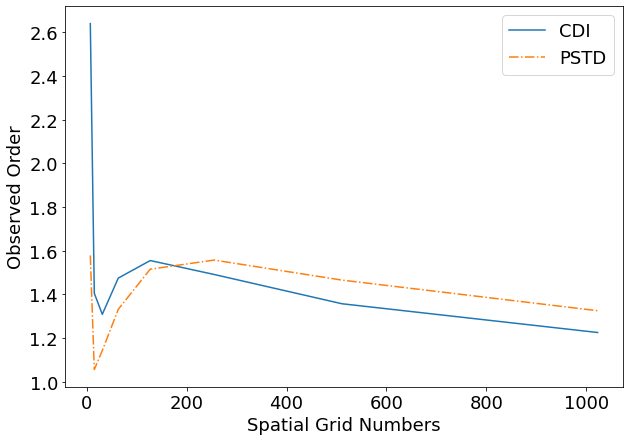

In [3]:
# Equation with decay terms 
# Spatial MMS tests
errorsx = np.ones((10, 2))
errornorms = np.ones(10)
nx = 32;
nt = 1000;
nxs = [7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]
nts = [250, 500, 1000, 2000, 4000]
for i in range(10):
    errornorms = mmstests(nxs[i], nt)
    errorsx[i, 0] = errornorms[0]
    errorsx[i, 1] = errornorms[1]
fig = plt.figure()
plt.figure()
fig.set_size_inches(10.,2.)
plt.plot(nxs, errorsx[:, 0], '-', label = 'CDI')
plt.plot(nxs, errorsx[:, 1], '.-', label = 'PSTD')

plt.xlabel('Grid Numbers')
plt.ylabel('Error Norms')
plt.legend()


px = np.zeros((8, 2))
for g in range(8):
    for k in range(2):
        px[g, k] = np.log((np.abs(errorsx[g+2, k]) - np.abs(errorsx[g+1, k]))/(np.abs(errorsx[g+1, k]) - np.abs(errorsx[g, k])))/(np.log(nxs[g]/nxs[g+1]))
fig = plt.figure()
fig.set_size_inches(10.,7.)
plt.plot(nxs[0:8], px[:, 0], '-', label = 'CDI')
plt.plot(nxs[0:8], px[:, 1], '-.', label = 'PSTD')

plt.xlabel('Spatial Grid Numbers')
plt.ylabel('Observed Order')
plt.legend()

# Printing the spatial grid tests

zipped1 = list(zip(nxs, errorsx[:, 0], errorsx[:, 1], px[:, 0], px[:, 1]))
df2 = pd.DataFrame(zipped1, columns=['Spatial Discretization Numbers', 'CDI_Error', 'PSTD_Error', 'CDI_Order', 'PSTD_Order'])

df2.to_csv('Analysis_Spectral15_Complete.csv', index=False)





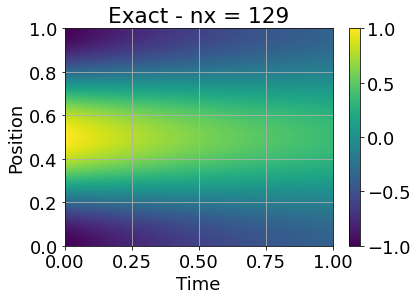

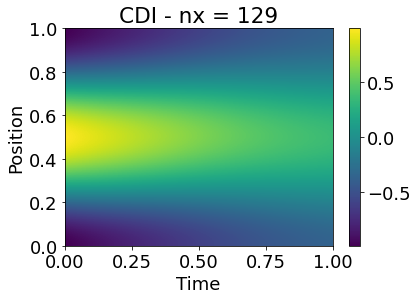

ValueError: operands could not be broadcast together with shapes (128,) (129,) 

In [4]:
# Equation with decay terms 

# Temporal MMS tests
errorsx = np.ones((6, 2))
errornorms = np.ones(6)
nx = 128;
nt = 1000;
nxs = [7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]
nts = [125, 250, 500, 1000, 2000, 4000]
for i in range(6):
    errornorms = mmstests(nx, nts[i])
    errorsx[i, 0] = errornorms[0]
    errorsx[i, 1] = errornorms[1]
fig = plt.figure()
plt.figure()
fig.set_size_inches(10.,2.)
plt.plot(nts, errorsx[:, 0], '-', label = 'CDI')
plt.plot(nts, errorsx[:, 1], '.-', label = 'PSTD')

plt.xlabel('Grid Numbers')
plt.ylabel('Error Norms')
plt.legend()


px = np.zeros((4, 2))
for g in range(4):
    for k in range(2):
        px[g, k] = np.log((np.abs(errorsx[g+2, k]) - np.abs(errorsx[g+1, k]))/(np.abs(errorsx[g+1, k]) - np.abs(errorsx[g, k])))/(np.log(nxs[g]/nxs[g+1]))
fig = plt.figure()
plt.plot(nts[0:4], px[:, 0], '-', label = 'CDI')
plt.plot(nts[0:4], px[:, 1], '-.', label = 'PSTD')

plt.xlabel('Temporal Grid Numbers')
plt.ylabel('Observed Order')
plt.legend()

# Printing the spatial grid tests

zipped1 = list(zip(nxs, errorsx[:, 0], errorsx[:, 1], px[:, 0], px[:, 1]))
df2 = pd.DataFrame(zipped1, columns=['Temporal Discretization Numbers', 'CDI_Error', 'PSTD_Error', 'CDI_Order', 'PSTD_Order'])

df2.to_csv('Analysis_Temporal125_Complete.csv', index=False)


In [ ]:





# def mmstestsc(nx, nt):
#     a=0.01
#     b=1.0;
#     c=0.5;

#     L = 1.0
#     T = 1.0

#     do=0;
#     Co=1;
#     x = np.linspace(0, L, nx+1)
#     t = np.linspace(0, T, nt+1)
#     xin = np.linspace(0, L, nx+1);
#     d = np.zeros((nx+1, nt+1));
#     U_exact= np.zeros((nx+1, nt+1))
#     for i in range(nt+1):
#         for j in range(nx+1):
#             U_exact[j, i] = Co*np.cos(np.pi*(2*x[j]-1))*np.exp(-t[i]) 
    
#     fig = plt.figure()  
#     plt.imshow((U_exact), cmap='viridis',  extent=[0, L, 0, T], aspect='auto')
#     plt.colorbar()
#     plt.title("CD Scheme with PSTD")
#     plt.xlabel('Position')
#     plt.ylabel('Time')
#     title = "Exact - nx = "+str(nx+1)
#     plt.title(title)
#     plt.grid(True)
#     plt.show()
#     plt.close()
    
#     for i in range(nt+1):
#         for j in range (nx+1):
#             d[j, i] = -(Co*np.exp(-t[i]))*(np.cos(np.pi*(2*x[j]-1)) - 2*b*np.pi*np.sin(np.pi*(2*x[j]-1)) - a*4*(np.pi**2)*np.cos(np.pi*(2*x[j]-1)) + c*np.cos(np.pi*(2*x[j]-1)))

#     # dt = 0.1*dx**2/D#T/(nt-1)
#     # dx = L/(nx+1)
#     # Discretization of space and time
#     dx = L/(nx)
#     dt = T/(nt)
#     u = Co*np.cos(np.pi*(2*x-1)) # np.exp(-x**2)#np.sin(np.pi*xin)
#     ui = u;
#     u_CDI  = u;

#     #plt.figure()
#     #plt.plot(u, label='Initial')
#     def numerical_scheme_CDI(u_CDI, a, b, c, d, dx, dt):
#         alpha = b*dt/dx
#         beta = a*dt/dx**2
#         nx = len(u_CDI)-1;
#         A = np.zeros((nx+1, nx+1))
#         bi = d*dt+u_CDI;
#         for j in range(1, len(u_CDI)-1):

#             A[j, j-1] = -(beta-alpha/2)
#             A[j, j] = 1+2*beta-c*dt
#             A[j, j+1] = -(beta+alpha/2)

#         # Applying first order Periodic Boundary Condition
#         A[0, 0]=(1+2*beta)-c*dt;
#         A[0, 1]= (-alpha/2-beta)
#         A[0, nx]= (alpha/2-beta)    


#         A[nx, 0]= (-alpha/2-beta) ;
#         A[nx, nx-1]= (alpha/2 - beta)
#         A[nx, nx]= 1+2*beta-c*dt   


#         # Applying second order periodic boundary conditions
#         # bt = d*dt+u_CDI;
#         # kk = np.zeros(2)
#         # bi = [*kk, *bt]

#         # A[0, 0]=0;
#         # A[0, 1]= 1
#         # A[0, N]= -1
#         # A[0, N+1]=0

#         # A[1, 0] = -1
#         # A[1,1] = 0
#         # A[1, 2] = 1
#         # A[1, N-1] = 1
#         # A[1, N] = 0 
#         # A[1, N+1] = -1


#         # Boundary condition
#         # A[0, 0] = -3
#         # A[0, 1] = 4
#         # A[0, 2] = -1
#         # bi[0] = 0

#         # A[N, N] = 3
#         # A[N, N-1] = -4
#         # A[N, N-2] = 1
#         # bi[N] = 0


#         # A[0,0] = 1.0
#         # # A[N,N] = 1.0

#         # bi[0] = l
#         # bi[N] = r


#         u_CDI = solve(A, bi)

#         return u_CDI



#     # Apply the numerical scheme
#     # u = np.exp(-((x+0.5)**2)/(0.00125))
#     U_CDI = np.zeros((nx+1, nt+1))
#     error_2norm_CDI_PSTD = np.zeros(nt+1)
#     error_2norm_Exact_CDI = np.zeros(nt+1)
#     error_2norm_Exact_PSTD = np.zeros(nt+1)
    
#     u_CDI=ui;

#     for n in range(nt+1):
#         u_CDI = numerical_scheme_CDI(u_CDI, a, b, c, d[:, n], dx, dt)
#         U_CDI[:, n] = u_CDI
#         error =  U_CDI[:, n] - U_exact[:, n]
        
#         error_2norm_Exact_CDI[n] =np.linalg.norm(error)/np.sqrt(nx)
#         errorCDI = error_2norm_Exact_CDI[n]

#     #plt.plot(u_CDI, label='Final')
#     #plt.show()
#     #plt.close()

#     plt.rcParams['font.size'] = 18
#     fig = plt.figure() 
#     plt.imshow(U_CDI, cmap='viridis', extent=[0, L, 0, T], aspect='auto')
#     plt.colorbar()
#     title = "CDI - nx = "+str(nx+1)
#     plt.title(title)
#     plt.xlabel('Position')
#     plt.ylabel('Time')
#     plt.show()


#     k = 2*np.pi*np.fft.rfftfreq(nx+1, L/(nx))
#     k2=k**2;

#     # Defining variables
#     U_ps = np.zeros((nx+1, nt+1))
#     u = ui;
#     # Solving over time
#     for i in range(nt+1): # 

#         uk = np.fft.rfft(u)

#         uk[:] = (uk[:])/(1-(-a*k**2 + b*1j*k+c)*dt) 
#         # print(np.shape(uk))    
#         u = np.fft.irfft(uk) + d[:, i]*dt
#         U_ps[:, i] = u
#         error =  U_CDI[:, i] - u
#         error_2norm_CDI_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
#         error =  U_ps[:, i] - U_exact[:, i]
#         error_2norm_Exact_PSTD[i] =np.linalg.norm(error)/np.sqrt(nx)
#         errorPSTD = error_2norm_Exact_PSTD[i]

#     fig = plt.figure()  
#     plt.imshow((U_ps), cmap='viridis',  extent=[0, L, 0, T], aspect='auto')
#     plt.colorbar()
#     plt.title("CD Scheme with PSTD")
#     plt.xlabel('Position')
#     plt.ylabel('Time')
#     title = "PSTDI - nx = "+str(nx+1)
#     plt.title(title)
#     plt.grid(True)
#     plt.show()
#     plt.close()

#     plt.figure()
#     plt.plot(error_2norm_CDI_PSTD[0:nt], '.', label = 'PSTDI_CDI')
#     plt.plot(error_2norm_Exact_PSTD[0:nt], '.', label = 'Exact_PSTDI')
#     plt.plot(error_2norm_Exact_CDI[0:nt], '.', label = 'Exact_CDI')
    
#     plt.legend()
#     plt.show()
#     plt.close()


#     plt.figure();
#     plt.plot(x, ui, '-', color='g', label = 'Initial'); 
#     plt.plot(x, U_exact[:, nt-1], '-*', color='c', label = 'Exact'); 

#     plt.plot(x, U_CDI[:, nt-1], '-*', color='b', label = 'CDI Method'); 
#     plt.plot(x, U_ps[:, nt-1], '-+', color = 'r', label = 'Spectral Method');
#     res =  [U_CDI[:, nt-1], U_ps[:, nt-1]]

#     plt.legend(loc="upper right")
#     title = "Comparison - nx = "+str(nx+1)
#     plt.title(title)
#     plt.show()
#     plt.close()
#     errornorms = np.ones(2)
#     errornorms[0] = errorCDI
#     errornorms[1] = errorPSTD
#     return errornorms


# # Equation with decay terms 

# # Spatial MMS tests
# errorsx = np.ones((10, 2))
# errornorms = np.ones(10)
# nx = 32;
# nt = 1000;
# nxs = [15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191]
# nts = [250, 500, 1000, 2000, 4000]
# for i in range(10):
#     errornorms = mmstests(nxs[i], nt)
#     errorsx[i, 0] = errornorms[0]
#     errorsx[i, 1] = errornorms[1]
# fig = plt.figure()
# plt.figure()
# fig.set_size_inches(10.,2.)
# plt.plot(nxs, errorsx[:, 0], '-', label = 'CDI')
# plt.plot(nxs, errorsx[:, 1], '.-', label = 'PSTD')

# plt.xlabel('Grid Numbers')
# plt.ylabel('Error Norms')
# plt.legend()

# fig = plt.figure()
# # fig.set_size_inches(10.,7.)
# px = np.zeros((7, 2))
# for g in range(8):
#     for k in range(2):
#         px[g, k] = np.log((np.abs(errorsx[g+2, k]) - np.abs(errorsx[g+1, k]))/(np.abs(errorsx[g+1, k]) - np.abs(errorsx[g, k])))/(np.log(nxs[g]/nxs[g+1]))

# plt.plot(nxs[0:8], px[:, 0], '-', label = 'CDI')
# plt.plot(nxs[0:8], px[:, 1], '-.', label = 'PSTD')

# plt.xlabel('Spatial Grid Numbers')
# plt.ylabel('Observed Order')
# plt.legend()

# # Printing the spatial grid tests

# zipped1 = list(zip(nxs, errorsx[:, 0], errorsx[:, 1], px[:, 0], px[:, 1]))
# df2 = pd.DataFrame(zipped1, columns=['Spatial Discretization Numbers', 'CDI_Error', 'PSTD_Error', 'CDI_Order', 'PSTD_Order'])

# df2.to_csv('Analysis_SpectralC15_Complete.csv', index=False)




